In [15]:
# Imports:
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import get_cmap
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import spearmanr

In [19]:
#Top level directory containing csv files:
csv_dir = './Atmotube folder'

In [21]:
# Use os.walk to search for all csv files in csv_dir:
all_csv_files = [
    # Join the directory name and file name ... :
    os.sep.join([csv_path, csv_file])
    # For each directory found by os.walk() ... :
    for csv_path, csv_subdirs, csv_files in os.walk(csv_dir)
    # for each file found by os.walk():
    for csv_file in csv_files
    # If the file name ends with '.csv':
    if csv_file.endswith('.csv')
]
#print(all_csv_files)

In [23]:
# The first 12 characters of each file name represent the MAC address of the device.
# We can use this to split the files in to groups, so we have a group of files for each device.

# Create a dict to store csv files by MAC:
csv_files = {}
# Loop through all of the csv files:
for csv_file in all_csv_files:
    # Get the MAC address from the file name by splitting the file path first by file
    # system separator, and then by underscore:
    mac_addr = csv_file.split(os.sep)[-1].split('_')[0]
    # If we have not seen this MAC address before, add an entry to csv_files dict:
    if mac_addr not in list(csv_files.keys()):
        csv_files[mac_addr] = []
    # Add this file to list for the sensor:
    csv_files[mac_addr].append(csv_file)

#print(csv_files)

In [24]:
# Create a list for storing all data frames:
all_data = []
# Init a count for sensor IDs:
sensor_count = 1

# While reading the data, we're going to store min and max dates, to get
# the time range for which we have data for all sensors:
min_date = None
max_date = None

# For each MAC address in the csv_files:
for mac_addr in list(csv_files.keys()):
    # Read all the csv files for this MAC address:
    mac_data = pd.concat([
        pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date', dayfirst=True)
        for csv_file in csv_files[mac_addr]
    ])   
    # Update min date for data:
    if not min_date:
        min_date = mac_data.index.min()
    elif mac_data.index.min() > min_date:
        min_date = mac_data.index.min()
    # Update mac date for data:
    if not max_date:
        max_date = mac_data.index.max()
    elif mac_data.index.max() < max_date:
        max_date = mac_data.index.max()
# ***        
    # If the sensors have different numbers of records, it may be necessary to
    # resample, so each sensor has the same number of records:
    mac_data = mac_data.resample('5T').mean()
# ***
    # Add a sensor ID column to data frame:
    mac_data['Sensor ID'] = sensor_count 
    # Store the data frame:
    all_data.append(mac_data)
    # Increment the sensor ID count:
    sensor_count += 1

# Merge all the data frames:
all_data = pd.concat(all_data)

all_data

,"VOC, ppm",AQS,"Temperature, °C","Humidity, %","Pressure, mbar","PM1, ug/m3","PM2.5, ug/m3","PM10, ug/m3",Latitude,Longitude,Sensor ID
Date,,,,,,,,,,,
2022-09-18 06:20:00,0.06540,95.6,11.0,59.0,1011.152,1.0,1.4,2.00,NaN,NaN,1
2022-09-18 06:25:00,0.06220,95.8,11.0,59.0,1011.170,1.0,1.2,2.20,NaN,NaN,1
2022-09-18 06:30:00,0.05580,96.2,11.0,59.0,1011.178,1.0,1.2,2.20,NaN,NaN,1
2022-09-18 06:35:00,0.05480,96.0,11.0,59.0,1011.238,1.0,1.4,2.00,NaN,NaN,1
2022-09-18 06:40:00,0.05860,96.0,11.0,59.0,1011.256,1.0,1.2,2.20,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-04 20:30:00,0.22000,86.2,17.8,69.0,1000.420,1.0,1.6,2.20,53.805761,-1.555652,31
2022-10-04 20:35:00,0.21960,86.2,17.8,69.0,1000.580,1.0,1.4,2.80,53.805757,-1.555612,31
2022-10-04 20:40:00,0.22020,86.0,17.8,69.0,1000.600,1.0,1.4,2.20,53.805754,-1.555626,31


In [28]:
# Extract data which falls between min_date and max_date, i.e.
# where we have data for all sensors:
data = all_data[
    (all_data.index >= min_date) &
    (all_data.index <= max_date)
]

# Check how many records we have for each sensor ID:
for sensor_id in range(1, sensor_count):
    data =data
    print(
        'Sensor ID: {0}, record count: {1}'.format(
            sensor_id, (data['Sensor ID'] == sensor_id).count() 
        ))
    data
#the result however gives a total number of records for all 31 sesors for each sensor
#that is, each sensor actually = N/31 = 62899/31
#Each sensor had 2029 records

Sensor ID: 1, record count: 62899
Sensor ID: 2, record count: 62899
Sensor ID: 3, record count: 62899
Sensor ID: 4, record count: 62899
Sensor ID: 5, record count: 62899
Sensor ID: 6, record count: 62899
Sensor ID: 7, record count: 62899
Sensor ID: 8, record count: 62899
Sensor ID: 9, record count: 62899
Sensor ID: 10, record count: 62899
Sensor ID: 11, record count: 62899
Sensor ID: 12, record count: 62899
Sensor ID: 13, record count: 62899
Sensor ID: 14, record count: 62899
Sensor ID: 15, record count: 62899
Sensor ID: 16, record count: 62899
Sensor ID: 17, record count: 62899
Sensor ID: 18, record count: 62899
Sensor ID: 19, record count: 62899
Sensor ID: 20, record count: 62899
Sensor ID: 21, record count: 62899
Sensor ID: 22, record count: 62899
Sensor ID: 23, record count: 62899
Sensor ID: 24, record count: 62899
Sensor ID: 25, record count: 62899
Sensor ID: 26, record count: 62899
Sensor ID: 27, record count: 62899
Sensor ID: 28, record count: 62899
Sensor ID: 29, record count: 

Sensor ID
1     AxesSubplot(0.125,0.11;0.775x0.77)
2     AxesSubplot(0.125,0.11;0.775x0.77)
3     AxesSubplot(0.125,0.11;0.775x0.77)
4     AxesSubplot(0.125,0.11;0.775x0.77)
5     AxesSubplot(0.125,0.11;0.775x0.77)
6     AxesSubplot(0.125,0.11;0.775x0.77)
7     AxesSubplot(0.125,0.11;0.775x0.77)
8     AxesSubplot(0.125,0.11;0.775x0.77)
9     AxesSubplot(0.125,0.11;0.775x0.77)
10    AxesSubplot(0.125,0.11;0.775x0.77)
11    AxesSubplot(0.125,0.11;0.775x0.77)
12    AxesSubplot(0.125,0.11;0.775x0.77)
13    AxesSubplot(0.125,0.11;0.775x0.77)
14    AxesSubplot(0.125,0.11;0.775x0.77)
15    AxesSubplot(0.125,0.11;0.775x0.77)
16    AxesSubplot(0.125,0.11;0.775x0.77)
17    AxesSubplot(0.125,0.11;0.775x0.77)
18    AxesSubplot(0.125,0.11;0.775x0.77)
19    AxesSubplot(0.125,0.11;0.775x0.77)
20    AxesSubplot(0.125,0.11;0.775x0.77)
21    AxesSubplot(0.125,0.11;0.775x0.77)
22    AxesSubplot(0.125,0.11;0.775x0.77)
23    AxesSubplot(0.125,0.11;0.775x0.77)
24    AxesSubplot(0.125,0.11;0.775x0.77)
25    

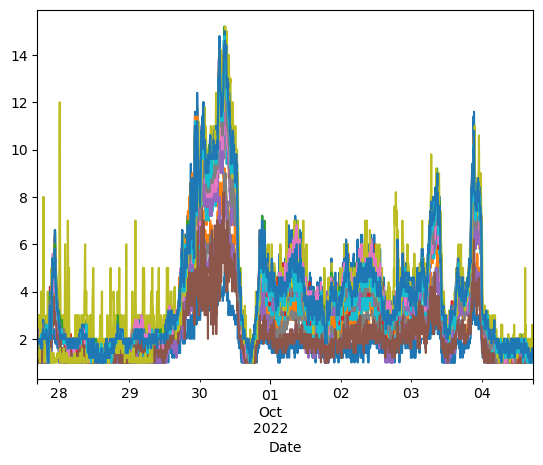

In [29]:
data.groupby('Sensor ID')['PM2.5, ug/m3'].plot()

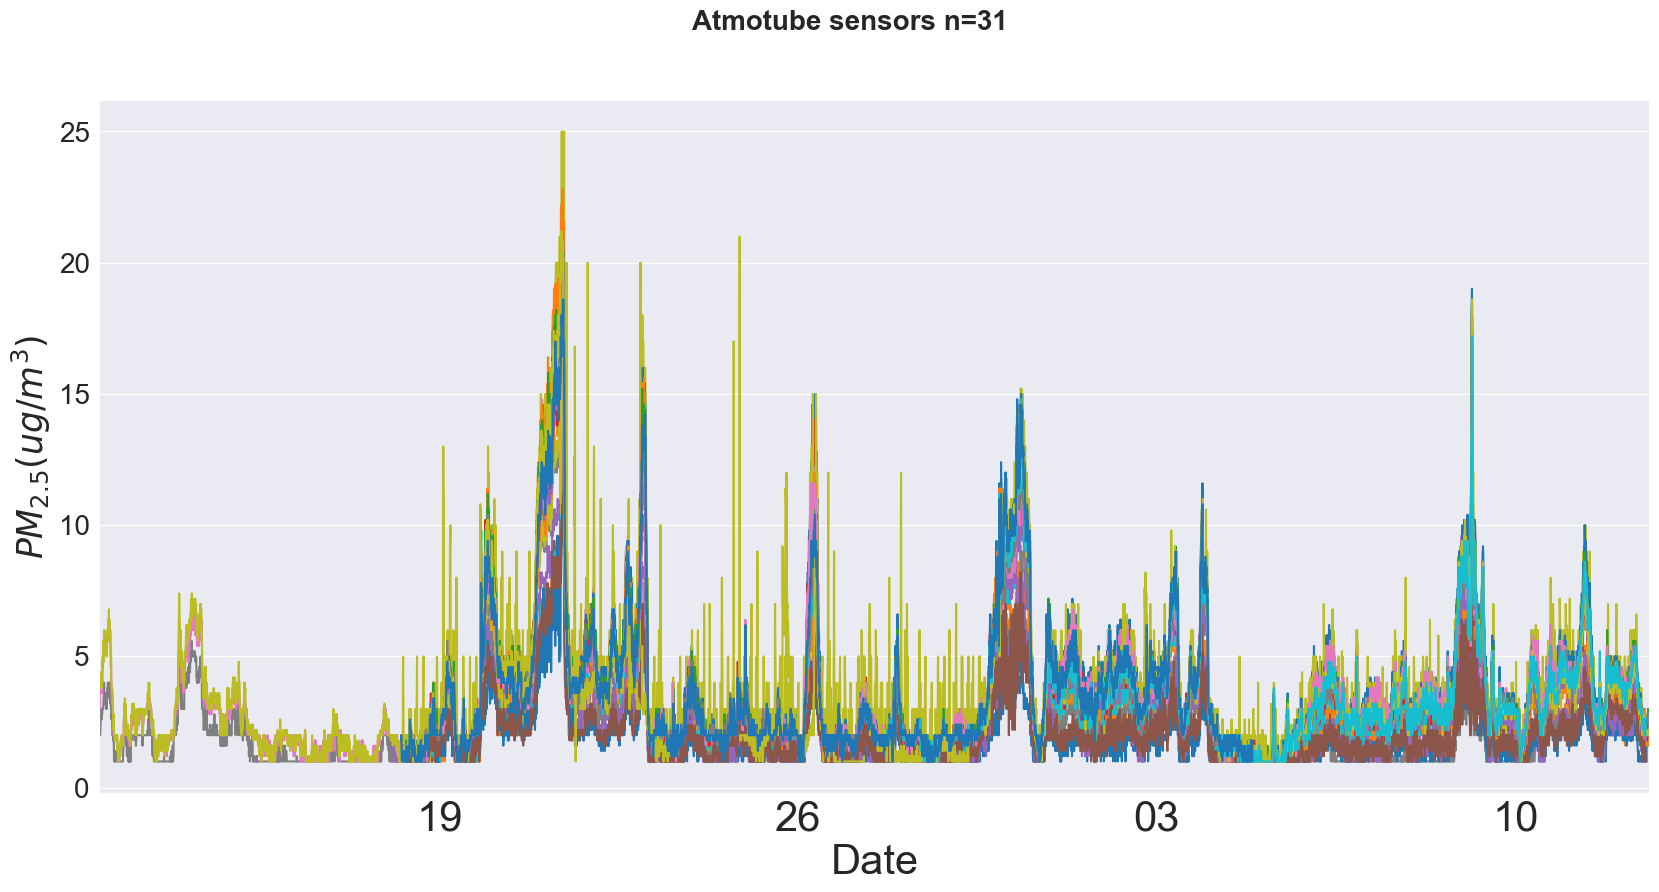

In [35]:
plt.rc('font', size=30)
sns.set_style('darkgrid')

plt.rcParams["figure.figsize"] = [20, 9]
name = "tab20"
all_data.groupby('Sensor ID')['PM2.5, ug/m3'].plot()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle('Atmotube sensors n=31', fontsize=20, weight='bold')
#plt.xlabel('xlabel')
plt.ylabel('$PM_{2.5} (ug/m^{3})$', fontsize=25, weight='bold')
#leg = ax.legend(prop={"size":16})
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

plt.margins(x=0)
#plt.savefig('31all_dataplot.png', dpi=600)
plt.show()

In [36]:
# This should produce a mean across all sensors:
mean_data = data.resample('5T').mean()
# Remove Sensor ID column - no longer relevant:
#mean_data.drop('Sensor ID', axis=1, inplace=True)
mean_data

,"VOC, ppm",AQS,"Temperature, °C","Humidity, %","Pressure, mbar","PM1, ug/m3","PM2.5, ug/m3","PM10, ug/m3",Latitude,Longitude,Sensor ID
Date,,,,,,,,,,,
2022-09-27 16:40:00,0.130019,91.774194,15.625806,38.438710,988.905355,1.0,1.703226,2.987097,53.805604,-1.555759,16.0
2022-09-27 16:45:00,0.125310,92.064516,15.587097,38.161290,988.900774,1.0,1.632258,2.967742,53.805559,-1.555723,16.0
2022-09-27 16:50:00,0.126748,91.909677,15.587097,38.238710,988.880903,1.0,1.625806,2.967742,53.805513,-1.555782,16.0
2022-09-27 16:55:00,0.130065,91.729032,15.574194,38.380645,988.878194,1.0,1.670968,3.019355,53.805466,-1.555872,16.0
2022-09-27 17:00:00,0.127781,91.845161,15.490323,38.741935,988.846774,1.0,1.741935,3.032258,53.805382,-1.555801,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-04 17:20:00,0.268342,83.335484,19.033548,62.303226,1000.787935,1.0,1.103226,2.129032,53.805777,-1.555676,16.0
2022-10-04 17:25:00,0.266942,83.445161,18.988387,62.387097,1000.745484,1.0,1.058065,2.141935,53.805806,-1.555633,16.0
2022-10-04 17:30:00,0.268935,83.283871,18.967742,62.554839,1000.597032,1.0,1.122581,2.154839,53.805734,-1.555659,16.0


In [37]:
std_data = data.resample('5T').std()
# Remove Sensor ID column - no longer relevant:
std_data.drop('Sensor ID', axis=1, inplace=True)
std_data

,"VOC, ppm",AQS,"Temperature, °C","Humidity, %","Pressure, mbar","PM1, ug/m3","PM2.5, ug/m3","PM10, ug/m3",Latitude,Longitude
Date,,,,,,,,,,
2022-09-27 16:40:00,0.052393,3.158794,0.995646,2.514183,0.682134,0.0,0.434729,0.531502,0.000397,0.000334
2022-09-27 16:45:00,0.052109,3.131512,1.134825,2.433883,0.680984,0.0,0.432348,0.508846,0.000358,0.000371
2022-09-27 16:50:00,0.052872,3.157568,1.198817,2.416289,0.684485,0.0,0.345415,0.453422,0.000400,0.000454
2022-09-27 16:55:00,0.054384,3.338482,1.070504,2.248172,0.689833,0.0,0.348515,0.426942,0.000483,0.000562
2022-09-27 17:00:00,0.057447,3.462065,1.031295,2.002794,0.690448,0.0,0.426438,0.511460,0.000660,0.000392
...,...,...,...,...,...,...,...,...,...,...
2022-10-04 17:20:00,0.036758,2.211719,1.024388,4.187560,0.627926,0.0,0.135361,0.210069,0.000173,0.000233
2022-10-04 17:25:00,0.035565,2.123965,1.040407,4.173228,0.637453,0.0,0.105749,0.194549,0.000260,0.000278
2022-10-04 17:30:00,0.037392,2.226971,1.017640,4.160035,0.628493,0.0,0.176465,0.235002,0.000232,0.000226


In [38]:
med_data = data.resample('5T').median()
# Remove Sensor ID column - no longer relevant:
med_data.drop('Sensor ID', axis=1, inplace=True)
med_data

,"VOC, ppm",AQS,"Temperature, °C","Humidity, %","Pressure, mbar","PM1, ug/m3","PM2.5, ug/m3","PM10, ug/m3",Latitude,Longitude
Date,,,,,,,,,,
2022-09-27 16:40:00,0.1288,92.000000,15.2,39.0,989.148,1.0,1.8,3.0,53.805813,-1.555607
2022-09-27 16:45:00,0.1206,92.000000,15.0,38.6,989.114,1.0,1.8,3.0,53.805739,-1.555591
2022-09-27 16:50:00,0.1206,92.200000,15.0,39.0,989.114,1.0,1.8,3.0,53.805731,-1.555638
2022-09-27 16:55:00,0.1288,92.000000,15.0,38.8,989.118,1.0,1.8,3.0,53.805736,-1.555628
2022-09-27 17:00:00,0.1256,92.000000,15.0,39.0,989.064,1.0,1.8,3.0,53.805717,-1.555593
...,...,...,...,...,...,...,...,...,...,...
2022-10-04 17:20:00,0.2680,83.200000,19.0,62.0,1000.998,1.0,1.0,2.0,53.805771,-1.555685
2022-10-04 17:25:00,0.2656,83.800000,19.0,62.0,1000.980,1.0,1.0,2.0,53.805765,-1.555685
2022-10-04 17:30:00,0.2662,83.400000,19.0,62.0,1000.858,1.0,1.0,2.0,53.805760,-1.555687


<AxesSubplot:xlabel='Date'>

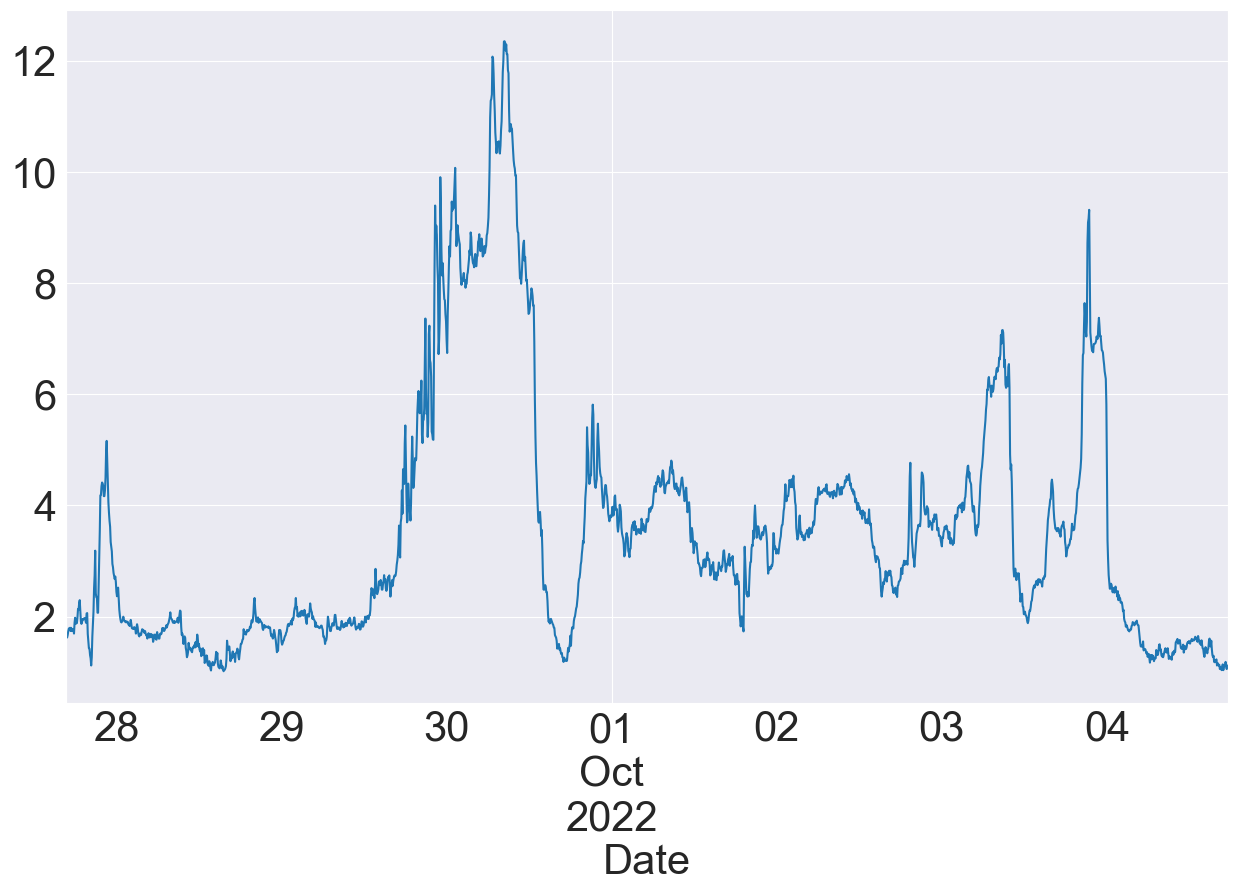

In [39]:
# Quick look at mean sensor PM2.5 data:
plt.rc('font', size=30)

plt.rcParams["figure.figsize"] = [15, 9]
mean_data['PM2.5, ug/m3'].plot()

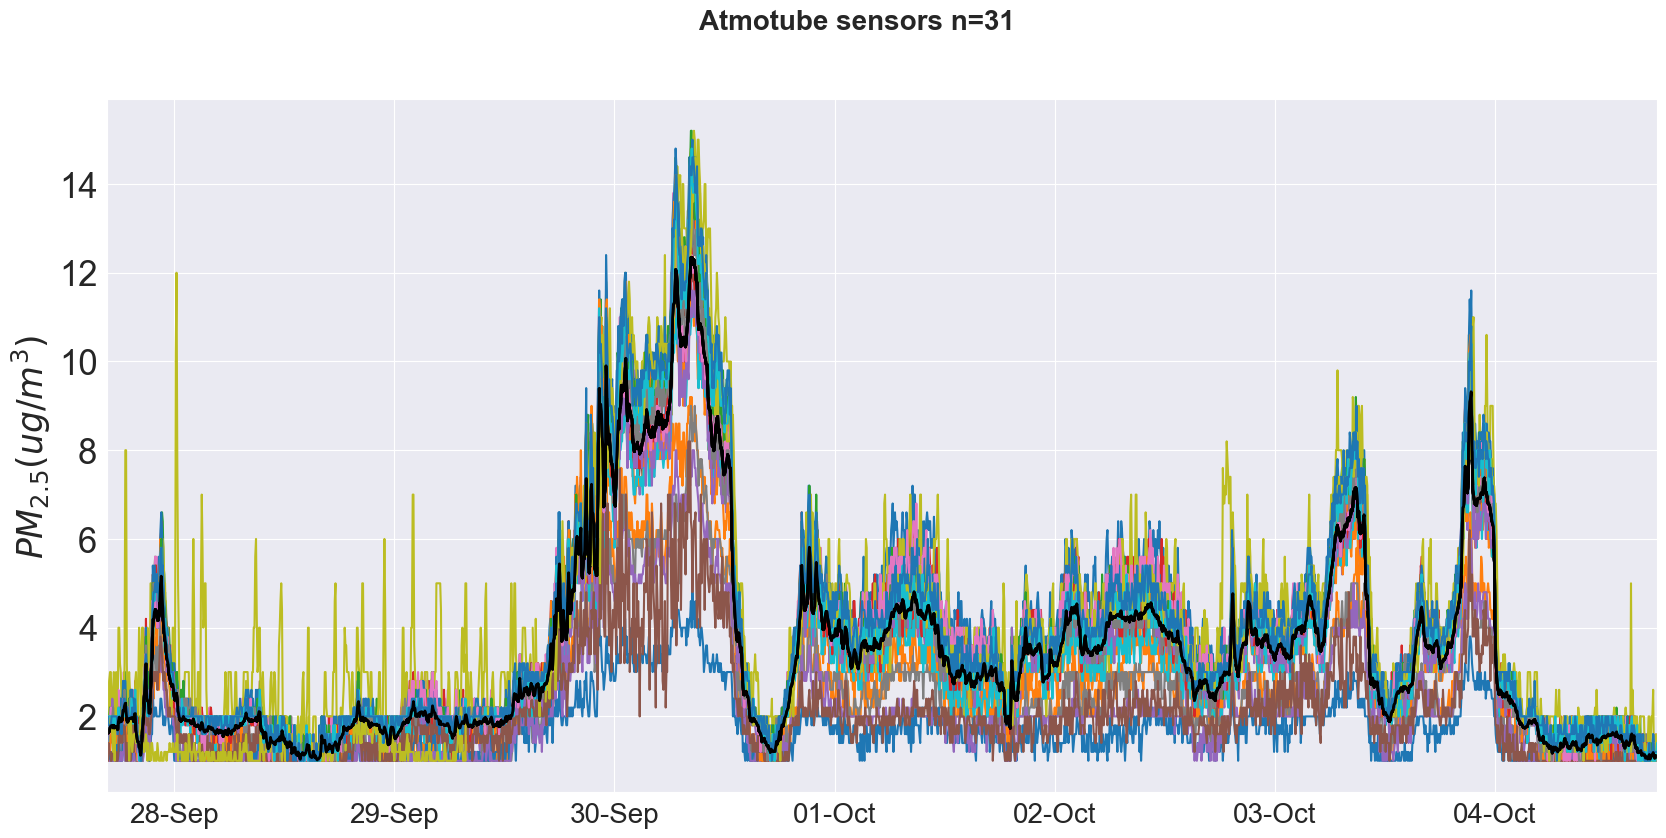

In [50]:
# Plot comparing each sensor with mean:
plt.rc('font', size=30)
sns.set_style('darkgrid')

plt.rcParams["figure.figsize"] = [20, 9]
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors 
#fig, axes = plt.subplots(nrows=2, ncols=1)
for sensor_id in range(1, sensor_count):
    #sns.kdeplot(mean_data.index, data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3'], label=sensor_id, fill=False, levels=10,shade=True, thresh=0.05)
    plt.plot(mean_data.index, data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3'], label=sensor_id) #color='grey')
    plt.plot(mean_data.index, mean_data['PM2.5, ug/m3'], color='black', linewidth=2.0)
        
#plt.legend()
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.suptitle('Atmotube sensors n=31', fontsize=20, weight='bold')
#plt.xlabel('xlabel')
plt.ylabel('$PM_{2.5} (ug/m^{3})$', fontsize=25, weight='bold')

#leg = ax.legend(prop={"size":16})
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

plt.margins(x=0)
#plt.gcf().autofmt_xdate() # Rotation
#plt.savefig('Atmotube31timeseriesvsmean.png', dpi=600)
plt.show()

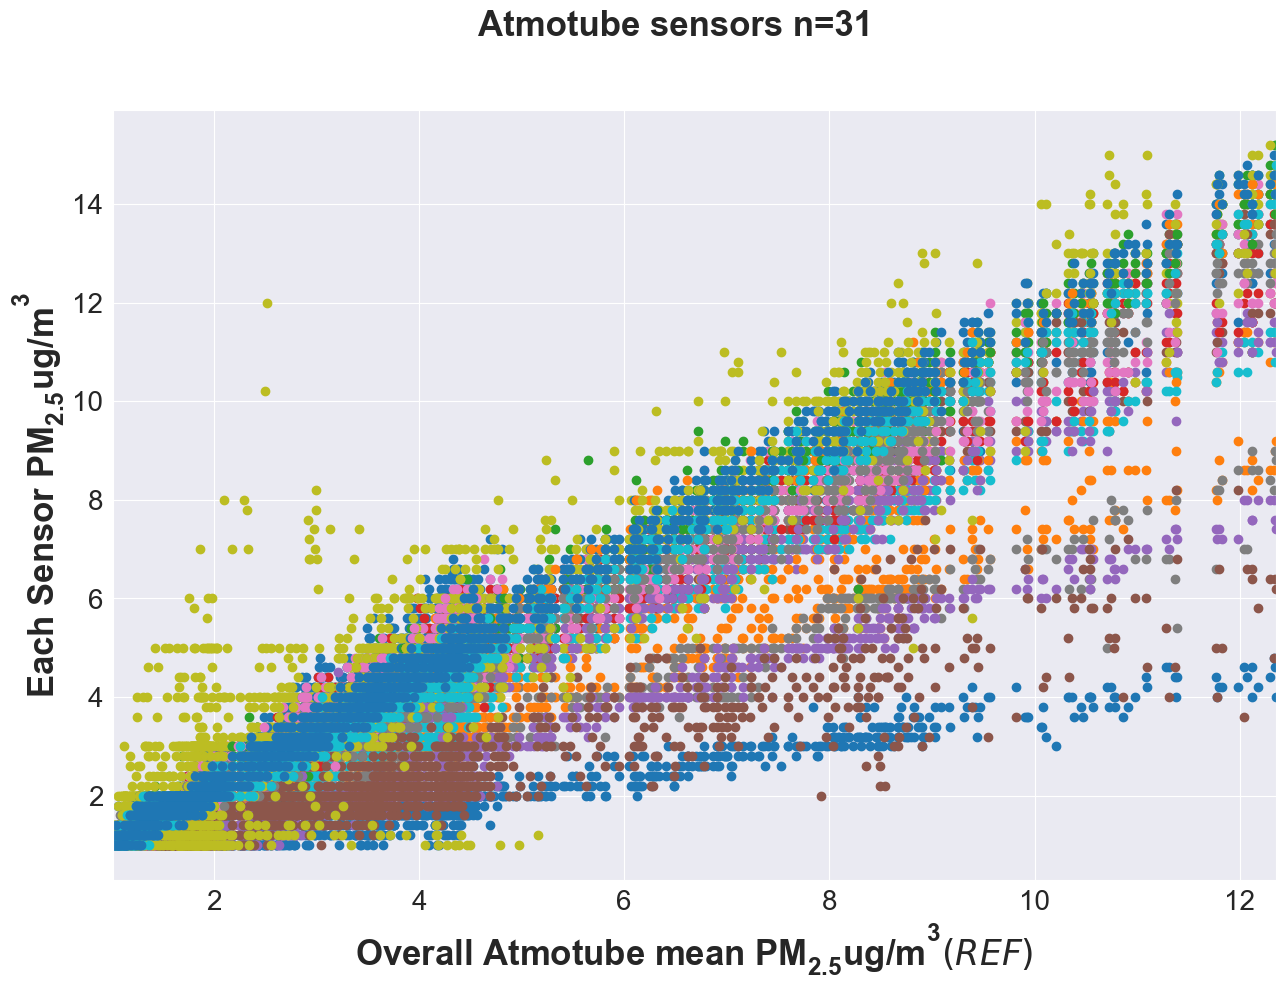

In [51]:
# Plot comparing each sensor with mean:
plt.rc('font', size=20)

plt.rcParams["figure.figsize"] = [15, 10]
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors 
for sensor_id in range(1, sensor_count):
    plt.scatter(mean_data['PM2.5, ug/m3'], data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3']) #color='grey')
#plt.legend()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle('Atmotube sensors n=31', fontsize=25, weight='bold')
#plt.xlabel('xlabel')
plt.ylabel( 'Each Sensor $\mathregular{PM_{2.5} ug/m^{3}}$', fontsize=25, weight='bold')
plt.xlabel( 'Overall Atmotube mean $\mathregular{PM_{2.5} ug/m^{3}} (REF)$', fontsize=25, weight='bold')
#leg = ax.legend(prop={"size":16})
ax = plt.gca()
plt.margins(x=0)
#plt.savefig('Atmotube31scatterplotvsoverallmeanref.png', dpi=600)
plt.show()

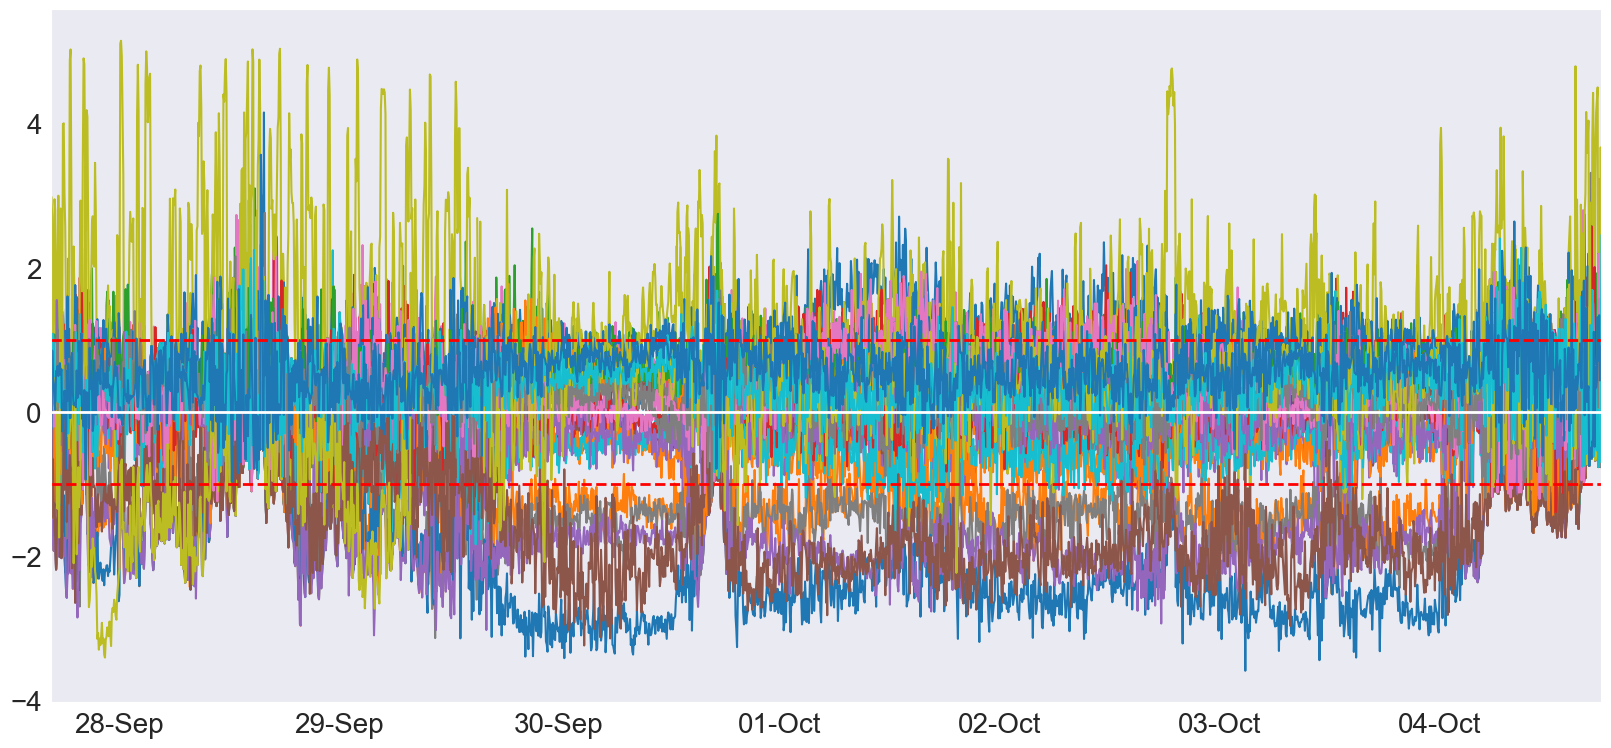

In [54]:
#Zscore plot for all 31 Atmotubes in a time series ((Each sensor - Mean Reference) / standard deviation data)

plt.rc('font', size=20)
sns.set_style('dark')
plt.rcParams["figure.figsize"] = [20, 9]
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors 
for sensor_id in range(1, sensor_count):
    plt.plot(mean_data.index,
             (data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3'] -mean_data['PM2.5, ug/m3']) / std_data['PM2.5, ug/m3'], label=sensor_id)
#plt.legend(fontsize='large')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.suptitle('mean-sensorconcentration/std', fontsize=50, weight='bold')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
#plt.ylabel('PM2.5ug/m3', fontsize=70, weight='bold')

#plt.gcf().autofmt_xdate() # Rotation
ax.axhline(1, color="red", linestyle="--", linewidth=2.0)
ax.axhline(-1, color="red", linestyle="--", linewidth=2.0)
ax.axhline(0, color="white", linestyle="-", linewidth=2.0)
plt.margins(x=0)
#plt.savefig('Atmotube31zscore_usingmean.png', dpi=600)
plt.show()

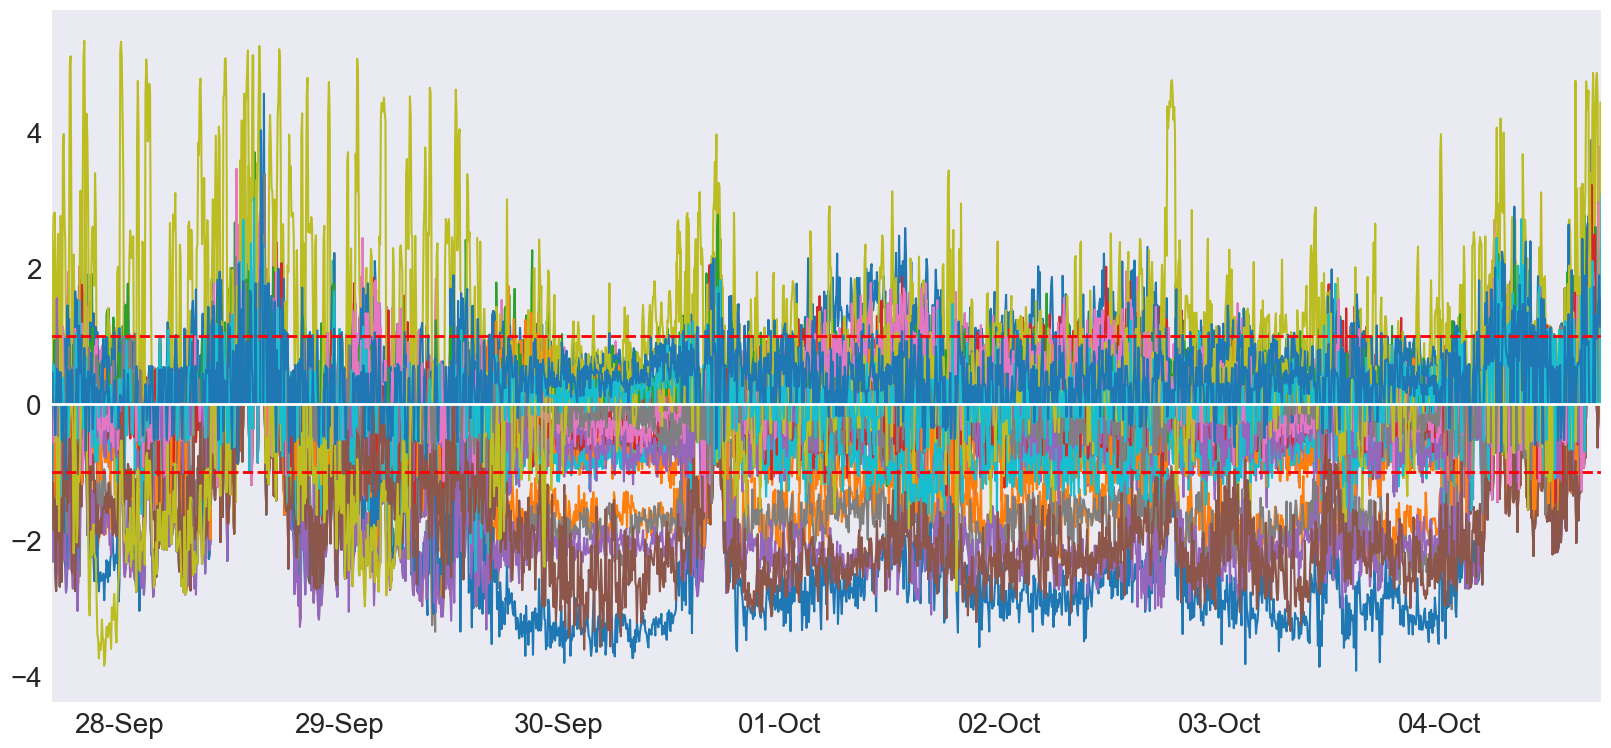

In [55]:
#Zscore plot for all 31 Atmotubes in a time series ((Each sensor - Median Reference) / standard deviation data)

plt.rc('font', size=20)
sns.set_style('dark')
plt.rcParams["figure.figsize"] = [20, 9]
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors 
for sensor_id in range(1, sensor_count):
    plt.plot(med_data.index,
             (data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3'] -med_data['PM2.5, ug/m3']) / std_data['PM2.5, ug/m3'], label=sensor_id)
#plt.legend(fontsize='large')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.suptitle('mean-sensorconcentration/std', fontsize=50, weight='bold')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
#plt.ylabel('PM2.5ug/m3', fontsize=70, weight='bold')

#plt.gcf().autofmt_xdate() # Rotation
ax.axhline(1, color="red", linestyle="--", linewidth=2.0)
ax.axhline(-1, color="red", linestyle="--", linewidth=2.0)
ax.axhline(0, color="white", linestyle="-", linewidth=2.0)
plt.margins(x=0)
#plt.savefig('Atmotube31zscore_usingmedian.png', dpi=600)
plt.show()

In [58]:
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
#calculate error bias for each sensor against the all31mean (REFERENCE)
for sensor_id in range(1, sensor_count):
    #for slope, intercept, R2, stderr and intercept_stder
    Reg=linregress(mean_data['PM2.5, ug/m3'], data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3'])
    #for mean absolute error 
    mae = mean_absolute_error(mean_data['PM2.5, ug/m3'], data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3'])
    # for mean squared error
    mse = mean_squared_error(mean_data['PM2.5, ug/m3'], data[data['Sensor ID'] == sensor_id]['PM2.5, ug/m3'])
    #for root mean squared error
    rmse = math.sqrt(mse)  
    print(
        'Sensor ID: {0}, Regression:\n {1}'.format(
            sensor_id, Reg)
        )

Sensor ID: 1, Regression:
 LinregressResult(slope=1.050036955496453, intercept=0.32710159417311546, rvalue=0.9801295903002449, pvalue=0.0, stderr=0.004720026388531891, intercept_stderr=0.01962362098667923)
Sensor ID: 2, Regression:
 LinregressResult(slope=0.7369024010726943, intercept=-0.12513792391699052, rvalue=0.989047881329856, pvalue=0.0, stderr=0.0024425162942987868, intercept_stderr=0.010154819076767076)
Sensor ID: 3, Regression:
 LinregressResult(slope=1.1422911780355418, intercept=-0.11152322449238028, rvalue=0.9957284410253355, pvalue=0.0, stderr=0.0023526263825878976, intercept_stderr=0.009781099649641328)
Sensor ID: 4, Regression:
 LinregressResult(slope=1.1270434717512654, intercept=0.037877400286305374, rvalue=0.9947934364022164, pvalue=0.0, stderr=0.0025645161380764754, intercept_stderr=0.010662036303463998)
Sensor ID: 5, Regression:
 LinregressResult(slope=0.9549566130654821, intercept=-0.20158928450725666, rvalue=0.9942676538635339, pvalue=0.0, stderr=0.002280926974189